In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve

shape of moons:  (10000, 2)


(-0.14058151734855812,
 0.1377439050776845,
 -0.2525119717674801,
 0.2594499397927031)

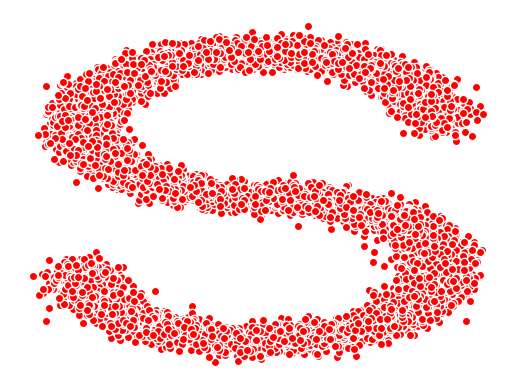

In [2]:
s_curve, _ = make_s_curve(10 ** 4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0
print("shape of moons: ", np.shape(s_curve))
data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color='red', edgecolor='white')
ax.axis('off')

In [3]:
import mindspore as ms

In [4]:
num_steps = 100

betas = ms.ops.linspace(ms.Tensor(-6).astype(ms.float32), ms.Tensor(6).astype(ms.float32), num_steps)
betas = ms.ops.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

alphas = 1 - betas
alphas_prod = ms.ops.cumprod(alphas, 0)
alphas_prod_p = ms.ops.concat([ms.Tensor([1]).astype(ms.float32), alphas_prod[:-1]], 0)
alphas_bar_sqrt = ms.ops.sqrt(alphas_prod)
one_minus_alphas_bar_log = ms.ops.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = ms.ops.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == one_minus_alphas_bar_sqrt.shape

print(betas.shape)

(100,)


In [5]:
# 加噪函数
def q_x(x_0, t):
    stdnormal = ms.ops.StandardNormal(seed=2)
    noise = stdnormal(x_0.shape)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [6]:
dataset = ms.Tensor(s_curve).astype(ms.float32)

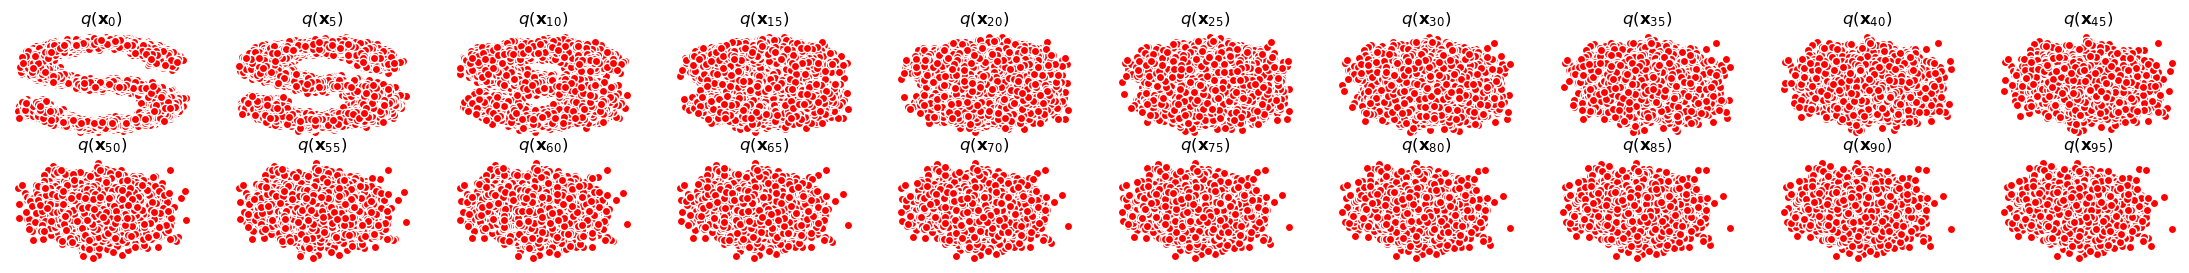

In [7]:
# 加噪过程
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')

for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, ms.Tensor([i * num_steps // num_shows]))
    axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolor='white')
    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{' + str(i * num_steps // num_shows) + '})$')

In [9]:
# 定义神经网络
import mindspore.nn as nn


class MLPDiffusion(nn.Cell):

    def __init__(self, n_steps, num_uints=128):
        super(MLPDiffusion, self).__init__()
        self.linears = nn.CellList(
            [
                nn.Dense(2, num_uints),
                nn.ReLU(),
                nn.Dense(num_uints, num_uints),
                nn.ReLU(),
                nn.Dense(num_uints, num_uints),
                nn.ReLU(),
                nn.Dense(num_uints, 2),
            ]
        )
        self.step_embeddings = nn.CellList(
            [
                nn.Embedding(n_steps, num_uints),
                nn.Embedding(n_steps, num_uints),
                nn.Embedding(n_steps, num_uints),
            ]
        )

    def construct(self, x_0, t):
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)
        return x

In [10]:
import numpy as np

In [11]:
# 扩散模型loss计算
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    t = ms.numpy.randint(0, n_steps, (batch_size // 2, ))
    t = ms.ops.concat([t, n_steps - 1 - t], axis=0)
    expand_dims = ms.ops.ExpandDims()
    t = expand_dims(t, -1)
    a = alphas_bar_sqrt[t]
    am1 = one_minus_alphas_bar_sqrt[t]
    e = ms.Tensor.from_numpy(np.random.standard_normal(x_0.shape)).astype(ms.float32)
    x = x_0 * a + e * am1
    output = model(x, t.squeeze(-1))
    return (e - output).square().mean()

In [12]:
# 去噪过程
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    cur_x = ms.Tensor.from_numpy(np.random.standard_normal(shape)).astype(ms.float32)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq


def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = ms.Tensor([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))
    z = ms.Tensor.from_numpy(np.random.standard_normal(x.shape)).astype(ms.float32)
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return (sample)

In [13]:
import mindspore.dataset as ds

epoch: 100, loss: 0.30832133
epoch: 200, loss: 0.22798967
epoch: 300, loss: 0.2956032
epoch: 400, loss: 0.22693346


KeyboardInterrupt: 

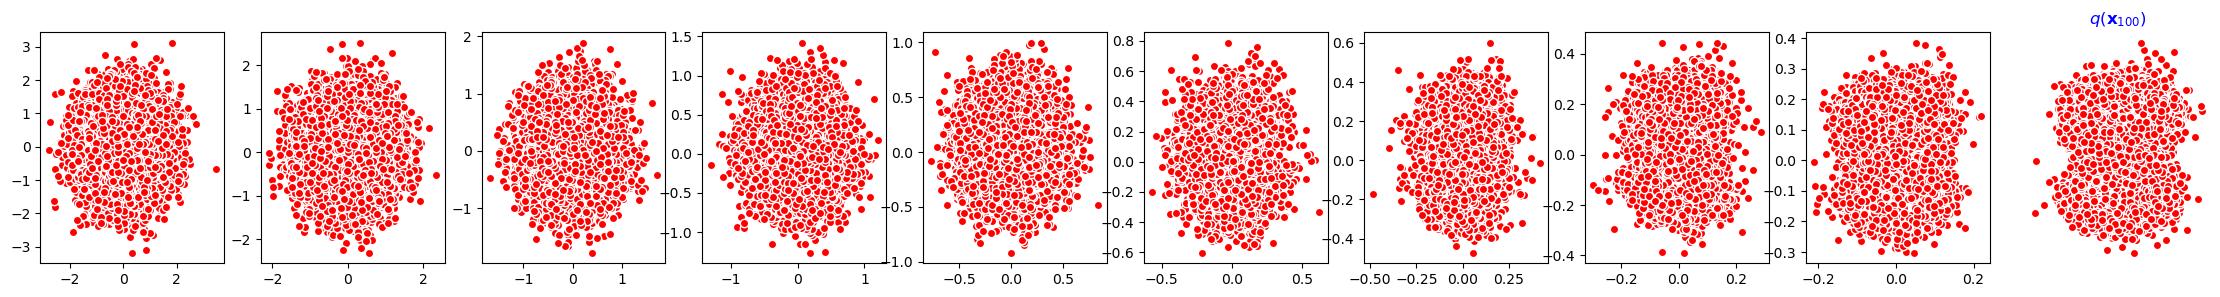

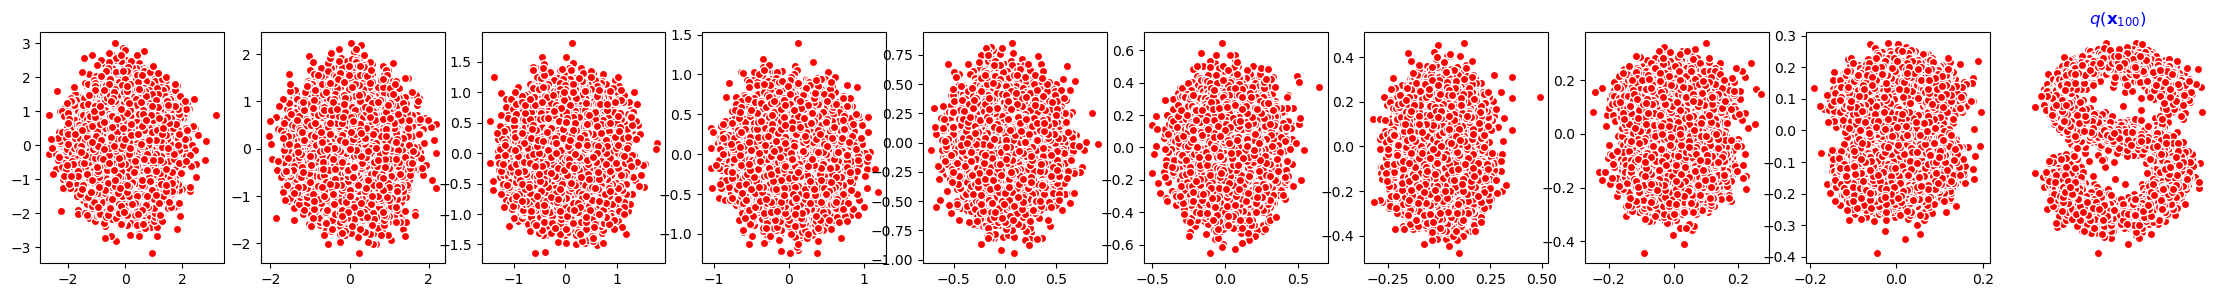

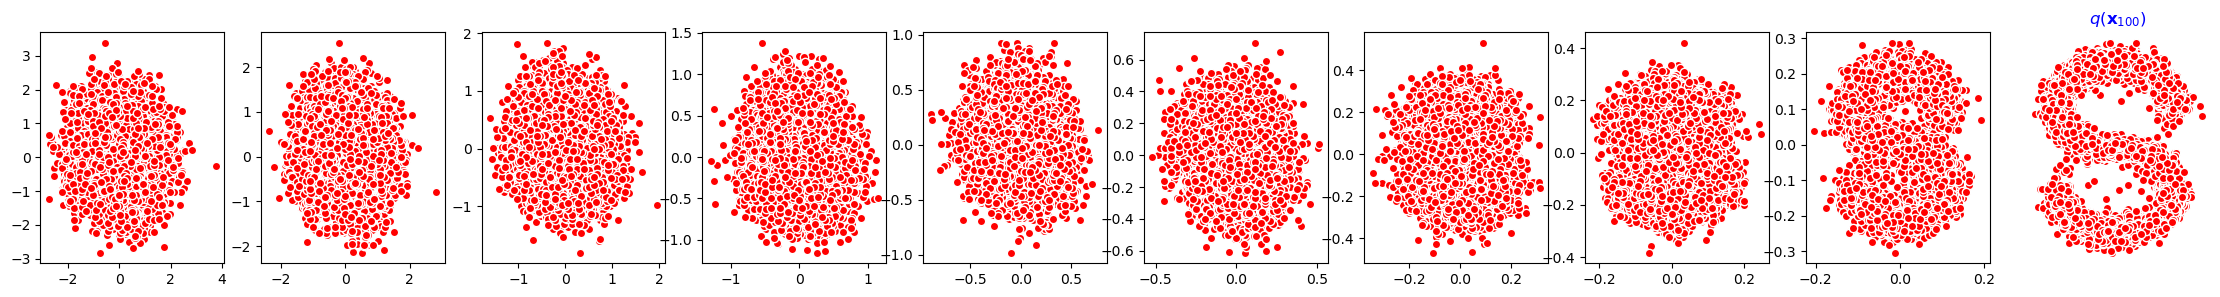

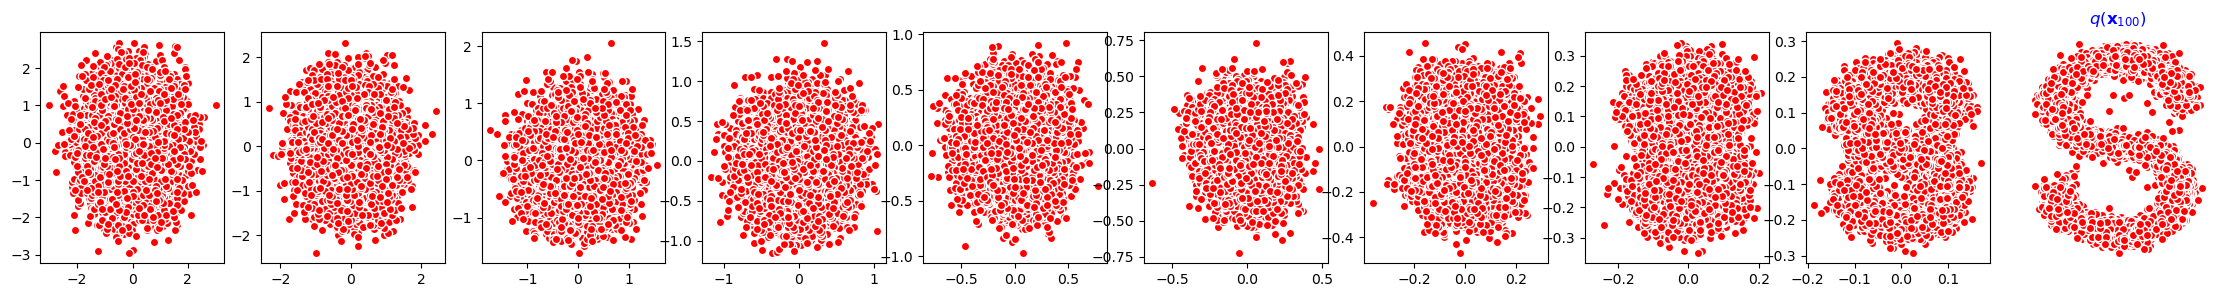

In [14]:
# 定义数据集
batch_size = 128
dataset_ds = ds.NumpySlicesDataset(data=s_curve, shuffle=True)
dataset_ds = dataset_ds.batch(batch_size)

num_epoch = 800
plt.rc('text', color='blue')

# 定义模型，优化器
model = MLPDiffusion(num_steps)
optimizer = ms.nn.Adam(model.trainable_params(), learning_rate=1e-3)

iterator = dataset_ds.create_dict_iterator()

# 前向计算过程
def forward_fn(batch_x):
    return diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)

# 定义梯度函数
grad_fn = ms.ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)


# 定义训练迭代
def train_step(batch_x):
    # 计算loss跟梯度
    loss, grads = grad_fn(batch_x)
    # 更新梯度
    loss = ms.ops.depend(loss, optimizer(grads))
    # 返回loss
    return loss

# 模型为训练模式
model.set_train()

# 开始训练
for t in range(num_epoch):
    for idx, batch_x in enumerate(iterator):
        loss = train_step(batch_x['column_0'].astype(ms.float32))

    # 在训练过程中打印loss变化及采样结果
    if ((t+1) % 100 == 0):
        print(f"epoch: {t+1}, loss: {loss}")
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

        fig, axs = plt.subplots(1, 10, figsize=(28, 3))

        for i in range(1, 11):
            cur_x = ms.ops.stop_gradient(x_seq[i * 10])
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
            axs[-1].set_axis_off()
            axs[-1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')